In [1]:
import numpy as onp

from uf3.jax.physical import stress_neighborlist_fn, stress_neighborlist_featurization_fn, stress_fn

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad, hessian
from jax import lax

from uf3.forcefield.calculator import *
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

from uf3.jax.potentials import uf3_pair, uf2_pair, uf3_neighbor

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, partition, util

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Loading potential from file

In [2]:
element_list = ['W']
degree = 2

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_pair.json")
calc2 = UFCalculator(model)

ndspline2 = calc2.pair_potentials[('W','W')]
c1 = jnp.asarray(calc2.coefficients[0])
c2 = jnp.asarray(ndspline2.coefficients)
c2 = c2[:,0]

coefficients_pair = [c1, c2]

In [3]:
element_list = ['W']
degree = 3

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {("W", "W"): 1.5,
             ("W", "W", "W"): [1.5, 1.5, 1.5],
            }
r_max_map = {("W", "W"): 5.5,
             ("W", "W", "W"): [3.5, 3.5, 7.0],
            }
resolution_map = {("W", "W"): 25,
                  ("W", "W", "W"): [5, 5, 10],
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_uf23.json")

calc3 = UFCalculator(model)

ndspline2 = calc3.pair_potentials[('W','W')]
ndspline3 = calc3.trio_potentials[('W','W','W')]
coefficients1 = jnp.asarray(calc3.coefficients[0])
coefficients2 = jnp.asarray(ndspline2.coefficients[:,0])

knots2 = [jnp.asarray(ndspline2.knots[0])]

coefficients3 = jnp.asarray(ndspline3.coefficients[:,:,:,0])

knots3 = ndspline3.knots
knots3 = [jnp.asarray(i) for i in knots3]

coefficients_uf23 = [coefficients1, coefficients2, coefficients3]
knots = [knots2, knots3]

## Building neighbor list and data

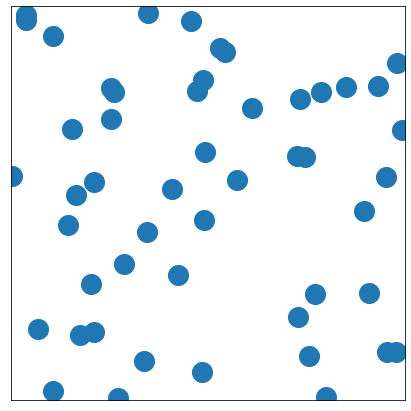

In [4]:
N = 50
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [5]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

In [6]:
species = onp.concatenate([onp.zeros(N//2), onp.ones(N-(N//2))])
rng = onp.random.default_rng()
rng.shuffle(species)
species = jnp.asarray(species, dtype=jnp.int16)
# print(species)
jnp.max(species)

DeviceArray(1, dtype=int16)

### Original ASE implementation

In [7]:
pos = np.array(R, np.float64)
c = onp.identity(3) * box_size
atoms = ase.Atoms('W'+str(len(pos)), positions=pos, cell=c, pbc=[True,True,True])

In [8]:
atoms.set_calculator(calc2)
print(atoms.get_potential_energy(force_consistent=True))
print(atoms.get_potential_energy(force_consistent=False))
print(atoms.get_forces()[:5])
print(atoms.get_stress(voigt=False))

15.986876951821294
-352.0040041042677
[[  1.2768243    1.70313186   0.23887351]
 [-10.44758428  -8.33767557   3.39379   ]
 [  2.60586324   4.97259042   3.89204412]
 [ -0.55074664   0.26743873   0.09513955]
 [ -2.53307871   2.15982274   2.61948677]]
[[-0.0311782   0.00348695  0.01053065]
 [ 0.00348695 -0.0967095   0.00455333]
 [ 0.01053065  0.00455333 -0.05696973]]


In [9]:
atoms.set_calculator(calc3)
print(atoms.get_potential_energy(force_consistent=True))
print(atoms.get_potential_energy(force_consistent=False))
print(atoms.get_forces()[:5])
print(atoms.get_stress(voigt=False))

-75.28736789560735
-420.7503645165807
[[-2.52646570e+01 -4.87098596e+01  3.50859164e+01]
 [-1.86978778e+02 -2.43239380e+02  5.51235884e+01]
 [ 1.04581521e+01  4.97714918e+00  3.46721515e+01]
 [-9.12927994e-01 -5.94236186e-02 -1.49492501e-01]
 [ 9.69840669e+01  6.55970930e+01  3.09038253e+01]]
[[ 0.2863429   0.19869209  0.17628195]
 [ 0.19869209  0.27075495 -0.25227657]
 [ 0.17628195 -0.25227657  0.20163524]]


## Potential

### Lennard-Jones

In [10]:
from jax_md.energy import lennard_jones_neighbor_list

nflj, eflj = lennard_jones_neighbor_list(displacement, box_size, r_cutoff=5.5)
nbrslj = nflj.allocate(R)
eflj = jit(eflj)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [11]:
eflj(R, nbrslj)

DeviceArray(2.6251813e+08, dtype=float64)

### Stillinger Weber

In [12]:
from jax_md.energy import stillinger_weber_neighbor_list
nfsw, efsw = stillinger_weber_neighbor_list(displacement, box_size, cutoff=5.5)
nbrssw = nfsw.allocate(R)
efsw = jit(efsw)

In [13]:
efsw(R, nbrssw)

DeviceArray(52377.53372771, dtype=float64)

### UF 2-body potential

In [14]:
pair2 = uf2_pair(displacement, knots[0], coefficients=coefficients_pair)

pair2 = jit(pair2)
pair2(R)

DeviceArray(-352.0040041, dtype=float64)

In [15]:
nf2, ef2 = uf3_neighbor(displacement, box_size, knots=knots[:-1], coefficients=coefficients_pair)
nbrs2 = nf2.allocate(R)
ef2 = jit(ef2)
print(ef2(R, nbrs2, coefficients=coefficients_pair[1:]))
print(ef2(R, nbrs2))

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


15.986876951821273
-352.0040041042677


In [16]:
grad(ef2)(R, nbrs2).shape

(50, 3)

In [17]:
box = jnp.eye(dimension) * box_size
stress_ufp2 = stress_neighborlist_fn(ef2, box)
stress_ufp2(R, nbrs2)

DeviceArray([[-0.03294612, -0.00098631,  0.00763032],
             [-0.00098631, -0.09284145,  0.00803835],
             [ 0.00763032,  0.00803835, -0.05203945]], dtype=float64)

In [18]:
hessian(ef2)(R, nbrs2).shape

(50, 3, 50, 3)

### UF3 3-body potential

In [19]:
pair3 = uf3_pair(displacement, knots, coefficients=coefficients_uf23)

pair3 = jit(pair3)
pair3(R)

DeviceArray(-420.75036452, dtype=float64)

In [20]:
nf3, ef3 = uf3_neighbor(displacement,box_size ,knots=knots, coefficients=coefficients_uf23[1:])
nbrs3 = nf3.allocate(R)

ef3 = jit(ef3)

print(ef3(R, neighbor=nbrs3, coefficients=coefficients_uf23[1:]))
print(ef3(R, neighbor=nbrs3, coefficients=coefficients_uf23))

-75.28736789560716
-420.7503645165805


### Dictionaies for UF potentials with species.

In [21]:
coeff_dict = {}
coeff_dict[(0,0)] = coefficients2
coeff_dict[(0,1)] = coefficients2
coeff_dict[(1,1)] = coefficients2

knot_dict = {}
knot_dict[(0,0)] = knots[0]
knot_dict[(0,1)] = knots[0]
knot_dict[(1,1)] = knots[0]

c3 = {}
c3[(0,0,0)] = coefficients3
c3[(0,0,1)] = coefficients3
c3[(0,1,1)] = coefficients3
c3[(1,0,0)] = coefficients3
c3[(1,0,1)] = coefficients3
c3[(1,1,1)] = coefficients3

k3 = {}
k3[(0,0,0)] = knots[1]
k3[(0,0,1)] = knots[1]
k3[(0,1,1)] = knots[1]
k3[(1,0,0)] = knots[1]
k3[(1,0,1)] = knots[1]
k3[(1,1,1)] = knots[1]

### UF 3-body potential with species

In [22]:
nf3s, ef3s = uf3_neighbor(displacement, box_size, species=species, knots=[knot_dict, k3], coefficients=[jnp.asarray([coefficients1]), coeff_dict, c3])
nbrs3s = nf3s.allocate(R)
ef3s = jit(ef3s)

In [23]:
print(ef3s(R, neighbor=nbrs3s, coefficients=[jnp.asarray([coefficients1]), coeff_dict, c3]))

-420.7503645165807


### UF 2-body potential with species

In [24]:
nf2s, ef2s = uf3_neighbor(displacement, box_size, species=species, knots=[knot_dict], coefficients=[coeff_dict])
nbrs2s = nf2s.allocate(R)
ef2s = jit(ef2s)

/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [25]:
print(ef2s(R, neighbor=nbrs2s, coefficients=[coeff_dict]))

114.27526073760461


### UF 2-body potential with featurization

In [35]:
nf2f, ef2f = uf3_neighbor(displacement, box_size, knots=knots[:-1], coefficients=coefficients_pair, featurization=True, force_features=False)
nbrs2f = nf2f.allocate(R)
ef2f = jit(ef2f)

In [36]:
ef2f(R, nbrs2f).shape

(50, 28)

In [38]:
jnp.sum(ef2f(R, nbrs2f))

DeviceArray(15.98687695, dtype=float64)

In [39]:
box = jnp.eye(dimension) * box_size

In [40]:
stress_ufp2f = stress_neighborlist_featurization_fn(ef2f, box)

In [47]:
s = stress_ufp2f(R, nbrs2f)
print(s.shape) # per atom per coefficient stress tensor
print(jnp.sum(s,0).shape) # per coefficient stress tensor
print(jnp.sum(s,[0,1])) # original system stress

(50, 28, 3, 3)
(28, 3, 3)
[[-0.03294612 -0.00098631  0.00763032]
 [-0.00098631 -0.09284145  0.00803835]
 [ 0.00763032  0.00803835 -0.05203945]]


### UF 3-body potential with featurization

In [32]:
nf3f, ef3f = uf3_neighbor(displacement,box_size ,knots=[knots2, knots3], featurization=True, force_features=False)
nbrs3f = nf3f.allocate(R[:50])

ef3f = jit(ef3f)

In [33]:
a, b = ef3f(R[:50], neighbor=nbrs3f, coefficients=[coefficients2, coefficients3])
print(a.shape)
print(b.shape)

(50, 28)
(50, 832)


In [34]:
jnp.sum(b) + jnp.sum(a)

DeviceArray(-264.84999653, dtype=float64)

## Benchmarks

In [35]:
key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64)
key, split = random.split(key)
Rc = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64)
pos = np.array(R, np.float64)
c = onp.identity(3) * box_size
atoms = ase.Atoms('W'+str(len(pos)), positions=pos, cell=c, pbc=[True,True,True])

In [36]:
nbrslj = nflj.allocate(R)
nbrssw = nfsw.allocate(R)
nbrs2 = nf2.allocate(R)
nbrs2s = nf2s.allocate(R)
nbrs3 = nf3.allocate(R)
nbrs3s = nf3s.allocate(R)

nbrsljc = nflj.allocate(Rc)
nbrsswc = nfsw.allocate(Rc)
nbrs2c = nf2.allocate(Rc)
nbrs2sc = nf2s.allocate(Rc)
nbrs3c = nf3.allocate(Rc)
nbrs3sc = nf3s.allocate(Rc)

In [37]:
e = [0.0] * 10 # energy benchmarks
f = [0.0] * 10 # forces benchmarks
s = [0.0] * 10 # stress benchmarks
h = [0.0] * 10 # hessian benchmarks

In [38]:
# Lennard-Jones
e[0] = %timeit -o eflj(R, nbrslj).block_until_ready()
flj = jit(grad(eflj))
flj(Rc, nbrsljc)
f[0] = %timeit -o flj(R, nbrslj).block_until_ready()
stress_lj = jit(stress_neighborlist_fn(eflj, box))
stress_lj(Rc, nbrs2c)
s[0] = %timeit -o stress_lj(R, nbrs2).block_until_ready()
fn = jit(hessian(eflj))
fn(Rc, nbrsljc)
h[0] = %timeit -o fn(R, nbrslj).block_until_ready()

59.7 µs ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
103 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
331 µs ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
175 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
# UFP ASE 2-body
atoms.set_calculator(calc2)
e[1] = %timeit -o atoms.get_potential_energy(force_consistent=True)
# e[1] = %timeit -o atoms.get_potential_energy(force_consistent=False)
f[1] = %timeit -o atoms.get_forces()
s[1] = %timeit -o atoms.get_stress(voigt=False)
h[1] = onp.nan

2.02 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.27 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.9 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
# UFP 2
e[2] = %timeit -o pair2(R).block_until_ready()
fp2 = jit(grad(pair2))
fp2(Rc)
f[2] = %timeit -o fp2(R).block_until_ready()
stress_uf2 = jit(stress_fn(pair2, box))
stress_uf2(Rc)
s[2] = %timeit -o stress_uf2(R).block_until_ready()
fn = jit(hessian(pair2))
fn(Rc)
h[2] = %timeit -o fn(R).block_until_ready()

282 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
260 µs ± 3.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
487 µs ± 3.89 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.01 ms ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [41]:
# UFP 2 neighbor-list
e[3] = %timeit -o ef2(R, nbrs2).block_until_ready()
f2 = jit(grad(ef2))
f2(Rc, nbrs2c)
f[3] = %timeit -o f2(R, nbrs2).block_until_ready()
stress_2 = jit(stress_neighborlist_fn(ef2, box))
stress_2(Rc, nbrs2c)
s[3] = %timeit -o stress_2(R, nbrs2).block_until_ready()
fn = jit(hessian(ef2))
fn(Rc, nbrs2c)
h[3] = %timeit -o fn(R, nbrs2).block_until_ready()

304 µs ± 86.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
236 µs ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
459 µs ± 75 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.03 ms ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
# UFP 2 multicomponent
e[4] = %timeit -o ef2s(R, nbrs2s).block_until_ready()
f2s = jit(grad(ef2s))
f2s(Rc, nbrs2sc)
f[4] = %timeit -o f2s(R, nbrs2s).block_until_ready()
stress_2s = jit(stress_neighborlist_fn(ef2s, box))
stress_2s(Rc, nbrs2sc)
s[4] = %timeit -o stress_2s(R, nbrs2s).block_until_ready()
fn = jit(hessian(ef2s))
fn(Rc, nbrs2sc)
h[4] = %timeit -o fn(R, nbrs2s).block_until_ready()

233 µs ± 51.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
339 µs ± 105 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
592 µs ± 146 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.5 ms ± 92.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
# Stillinger-Weber
e[5] = %timeit -o efsw(R, nbrssw).block_until_ready()
fsw = jit(grad(efsw))
fsw(Rc, nbrsswc)
f[5] = %timeit -o fsw(R, nbrssw).block_until_ready()
stress_sw = jit(stress_neighborlist_fn(efsw, box))
stress_sw(Rc, nbrsswc)
s[5] = %timeit -o stress_sw(R, nbrssw).block_until_ready()
fn = jit(hessian(efsw))
fn(Rc, nbrsswc)
h[5] = %timeit -o fn(R, nbrssw).block_until_ready()

142 µs ± 6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
217 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
458 µs ± 70.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.75 ms ± 97.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
# UFP ASE 3-body
atoms.set_calculator(calc3)
e[6] = %timeit -o atoms.get_potential_energy(force_consistent=True)
# e[6] = %timeit -o atoms.get_potential_energy(force_consistent=False)
f[6] = %timeit -o atoms.get_forces()
s[6] = %timeit -o atoms.get_stress(voigt=False)
h[6] = onp.nan

23.7 ms ± 89.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
167 ms ± 739 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
286 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
# UFP 3
e[7] = %timeit -o pair3(R).block_until_ready()
fp3 = jit(grad(pair3))
fp3(Rc)
f[7] = %timeit -o fp3(R).block_until_ready()
stress_uf3 = jit(stress_fn(pair3, box))
stress_uf3(Rc)
s[7] = %timeit -o stress_uf3(R).block_until_ready()
fn = jit(hessian(pair3))
fn(Rc)
h[7] = %timeit -o fn(R).block_until_ready()
# h[7] = onp.nan

811 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.79 ms ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.99 ms ± 8.88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
894 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
# UFP 3 neighbor-list
e[8] = %timeit -o ef3(R, nbrs3).block_until_ready()
f3 = jit(grad(ef3))
f3(Rc, nbrs3c)
f[8] = %timeit -o f3(R, nbrs3).block_until_ready()
stress_3 = jit(stress_neighborlist_fn(ef3, box))
stress_3(Rc, nbrs3c)
s[8] = %timeit -o stress_3(R, nbrs3).block_until_ready()
fn = jit(hessian(ef3))
fn(Rc, nbrs3c)
h[8] = %timeit -o fn(R, nbrs3).block_until_ready()
# h[8] = onp.nan

808 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.3 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.58 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
778 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
# UFP 3 multicomponent
e[9] = %timeit -o ef3s(R, nbrs3s).block_until_ready()
f3s = jit(grad(ef3s))
f3s(Rc, nbrs3sc)
f[9] = %timeit -o f3s(R, nbrs3s).block_until_ready()
stress_3s = jit(stress_neighborlist_fn(ef3s, box))
stress_3s(Rc, nbrs3sc)
s[9] = %timeit -o stress_3s(R, nbrs3s).block_until_ready()
fn = jit(hessian(ef3s))
fn(Rc, nbrs3sc)
h[9] = %timeit -o fn(R, nbrs3s).block_until_ready()
# h[9] = onp.nan

832 µs ± 386 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.14 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.46 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.53 s ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Benchmark Results

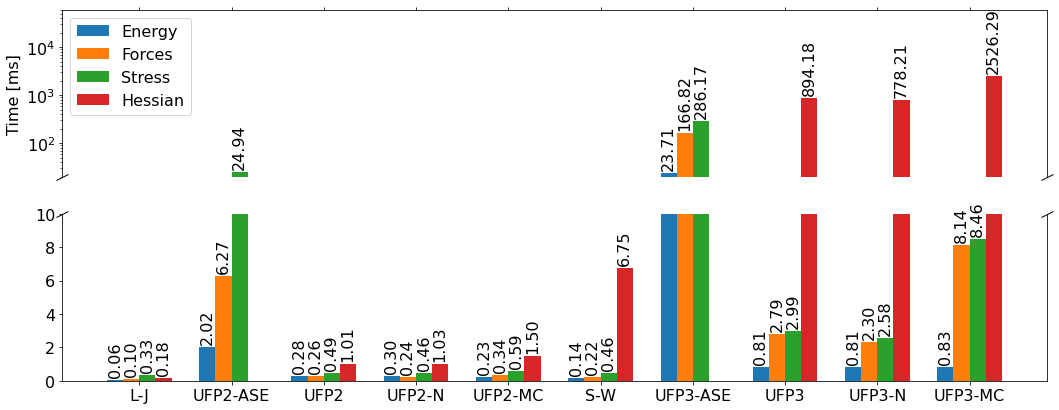

In [83]:
labels = [
    "L-J",
    "UFP2-ASE",
    "UFP2",
    "UFP2-N",
    "UFP2-MC",
    "S-W",
    "UFP3-ASE",
    "UFP3",
    "UFP3-N",
    "UFP3-MC",
]
do = lambda x: x if x == 0.0 or (type(x) == float and onp.isnan(x)) else x.average * 1e3
energies = [do(E) for E in e]
forces = [do(F) for F in f]
stress = [do(S) for S in s]
hessians = [do(H) for H in h]

x = onp.arange(len(labels[:]))  # the label locations
width = 0.35 /2 # the width of the bars

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
fig.subplots_adjust(hspace=5e-10)

rects1 = ax1.bar(x - width *3/ 2, energies[:], width, label="Energy")
rects2 = ax1.bar(x- width /2, forces[:], width, label="Forces")
rects3 = ax1.bar(x + width / 2, stress[:], width, label="Stress")
rects4 = ax1.bar(x + width * 3 / 2, hessians[:], width, label="Hessian")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel("Time [ms]")
ax1.set_xticks(x, labels[:])
ax1.legend()

ax1.bar_label(rects1, padding=3, fmt="%.2f", rotation='vertical')
ax1.bar_label(rects2, padding=3, fmt="%.2f", rotation='vertical')
ax1.bar_label(rects3, padding=3, fmt="%.2f", rotation='vertical')
ax1.bar_label(rects4, padding=3, fmt="%.2f", rotation='vertical')

rects1 = ax2.bar(x - width *3/2, energies[:], width, label="Energy")
rects2 = ax2.bar(x - width /2, forces[:], width, label="Forces")
rects3 = ax2.bar(x + width / 2, stress[:], width, label="Stress")
rects4 = ax2.bar(x + width * 3 / 2, hessians[:], width, label="Hessian")

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax2.set_ylabel("Time [ms]")
ax2.set_xticks(x, labels[:])
# ax2.legend()

ax2.bar_label(rects1, padding=3, fmt="%.2f", rotation='vertical')
ax2.bar_label(rects2, padding=3, fmt="%.2f", rotation='vertical')
ax2.bar_label(rects3, padding=3, fmt="%.2f", rotation='vertical')
ax2.bar_label(rects4, padding=3, fmt="%.2f", rotation='vertical')

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_ylim(20, 60000)
ax1.set_yscale('log')
ax2.set_ylim(0, 10)

fig.tight_layout()

plt.show()

fig.savefig('potentials-benchmark.png', dpi=fig.dpi)


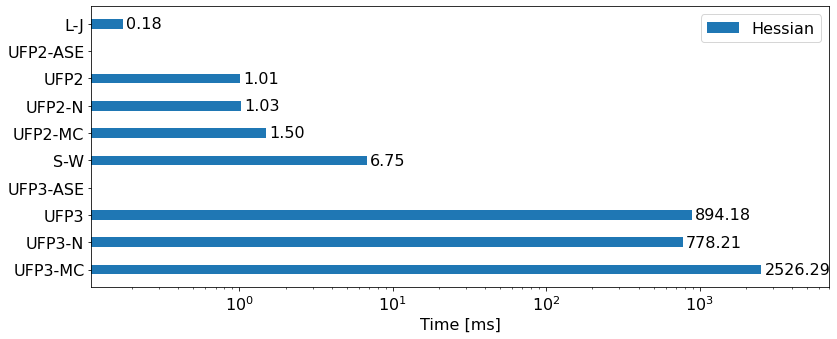

In [49]:
labels = [
    "L-J",
    "UFP2-ASE",
    "UFP2",
    "UFP2-N",
    "UFP2-MC",
    "S-W",
    "UFP3-ASE",
    "UFP3",
    "UFP3-N",
    "UFP3-MC",
]
do = lambda x: x if x == 0.0 or (type(x) == float and onp.isnan(x)) else x.average * 1e3
hessians = [do(H) for H in h]

x = onp.arange(len(labels[:]))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 5))
rects4 = ax1.barh(x, hessians[:][::-1], width, label="Hessian")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel("Time [ms]")
ax1.set_xscale('log')
ax1.set_yticks(x, labels[:][::-1])
ax1.set_xbound(upper=7000)
ax1.legend()

# ax1.bar_label(rects1, padding=3, fmt="%.2f", rotation='vertical')
# ax1.bar_label(rects2, padding=3, fmt="%.2f", rotation='vertical')
# ax1.bar_label(rects3, padding=3, fmt="%.2f", rotation='vertical')
ax1.bar_label(rects4, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

fig.savefig('potentials-benchmark-hessian.png', dpi=fig.dpi)


## Scaling Benchmark

In [36]:
box_size = 20.0

f_lj = []
f_sw = []
f_uf2 = []
f_uf3 = []

for N in range(50,501,50):
    print(f"For {N} atoms:")
    key, split = random.split(key)
    R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64)
    key, split = random.split(key)
    Rc = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64)
    
    nbrslj = nflj.allocate(R)
    nbrssw = nfsw.allocate(R)
    nbrs2 = nf2.allocate(R)
    nbrs3 = nf3.allocate(R)

    nbrsljc = nflj.allocate(Rc)
    nbrsswc = nfsw.allocate(Rc)
    nbrs2c = nf2.allocate(Rc)
    nbrs3c = nf3.allocate(Rc)
    
    flj = jit(grad(eflj))
    flj(Rc, nbrsljc)
    tmp = %timeit -o flj(R, nbrslj).block_until_ready()
    f_lj.append(tmp)
    
    fsw = jit(grad(efsw))
    fsw(Rc, nbrsswc)
    tmp = %timeit -o fsw(R, nbrssw).block_until_ready()
    f_sw.append(tmp)
    
    f2 = jit(grad(ef2))
    f2(Rc, nbrs2c)
    tmp = %timeit -o f2(R, nbrs2).block_until_ready()
    f_uf2.append(tmp)
    
    f3 = jit(grad(ef3))
    f3(Rc, nbrs3c)
    tmp = %timeit -o f3(R, nbrs3).block_until_ready()
    f_uf3.append(tmp)

For 50 atoms:
99.3 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
176 µs ± 225 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
174 µs ± 487 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.21 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
For 100 atoms:
92.2 µs ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
377 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
224 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.83 ms ± 33.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
For 150 atoms:
103 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
848 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
216 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.3 ms ± 87.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
For 200 atoms:
119 µs ± 6.44 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.61 ms ± 33.5 µs per loop (mean ± std.

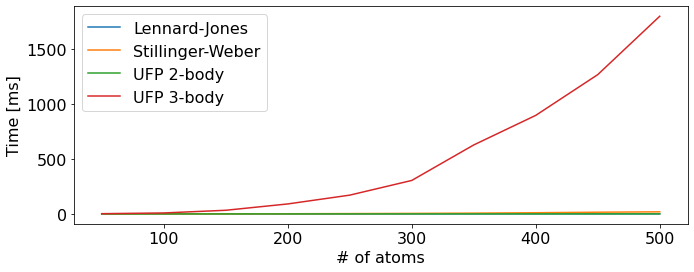

In [45]:
fig, ax = plt.subplots(figsize=(11,4))

x = list(range(50,501,50))
do = lambda x: x if x == 0.0 or (type(x) == float and onp.isnan(x)) else x.average * 1e3

y = [do(f) for f in f_lj]
ax.plot(x, y, label='Lennard-Jones')

y = [do(f) for f in f_sw]
ax.plot(x, y, label='Stillinger-Weber')

y = [do(f) for f in f_uf2]
ax.plot(x, y, label='UFP 2-body')

y = [do(f) for f in f_uf3]
ax.plot(x, y, label='UFP 3-body')
# ax.set_xscale('log')
ax.set_xlabel("# of atoms")
# ax.set_yscale('log')
ax.set_ylabel("Time [ms]")
ax.legend()
        
plt.show()
fig.tight_layout()
fig.savefig('potential-force-scaling-benchmark.png', dpi=fig.dpi)